# Praca domowa 5 
### Mateusz Krzyziński, grupa 2


Zadanie to polega na przetestowaniu różnych metod klasteryzujących na zadanym zbiorze oraz doborze optymalnej liczby klastrów na podstawie wybranych metryk/wykresów/analiz.

#### Import pakietów

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Wczytanie danych

In [79]:
df = pd.read_csv("https://raw.githubusercontent.com/mini-pw/2021L-WUM/main/Prace_domowe/Praca_domowa5/clustering.csv", \
                 header = None, names = ["x", "y"])

In [80]:
df.head(10)

,x,y
0,41.788907,52.220182
1,-96.586516,90.957033
2,-54.143591,-99.153377
3,19.929231,-45.859779
4,-82.941076,84.099186
5,13.389996,-4.016202
6,-26.104987,8.618031
7,-15.625451,67.370573
8,85.259069,14.681990
9,33.039866,-49.611486


In [81]:
df.describe() 

,x,y
count,400.000000,400.000000
mean,-0.580656,-8.010264
std,48.821210,62.096845
min,-107.433649,-128.983720
25%,-34.551495,-70.730416
50%,5.691010,-3.447565
75%,31.456507,45.822610
max,109.733409,99.935839


Oba wymiary naszych danych mają podobne wartości - zakres i rząd wielkości. Zatem skalowanie nie jest konieczne, ale przetestuję też w ramach sprawdzenia, jak zostanie wykonana klasteryzacja na danych przeskalowanych. 

### Wstępna analiza

Najpierw jednak zobaczmy, jak wygląda nasz zbiór na płaszczyźnie, by mieć intuicję odnośnie klastrów. Warto tu określić wymiary wykresu na kwadratowe i jednakowy zakres osi, by nie przekłamywać odbioru. 

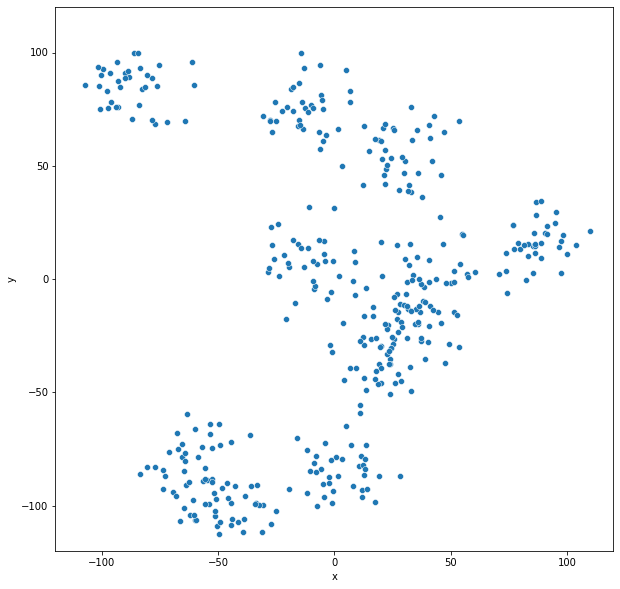

In [82]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="x", y="y", data = df)
plt.ylim([-120, 120])
plt.xlim([-120, 120])
plt.show()

W zależności od interpretacji można myśleć tutaj najprawdopodobniej o 7-9 klastrach. Przynajmniej taka jest moja intuicja, patrząc na wyrysowane punkty. 


### Klasteryzacja metodą k-średnich

Przetestujemy najpierw klasteryzację metodą k-średnich. W celu doboru optymalnej liczby klastrów zdamy się na metodę łokcia, a więc minimalizującą sumę kwadratów odległości między punktami a najbliższymi środkami klastrów. Ponadto dla upewnienia wykorzystamy metodę silhouette określającą podobieństwo obiektu do innych obiektów w tym samym klastrze.

In [83]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

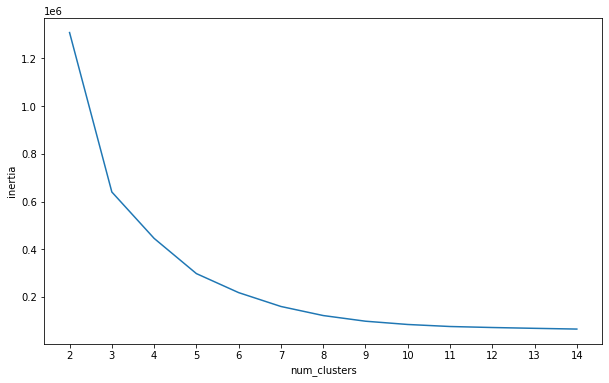

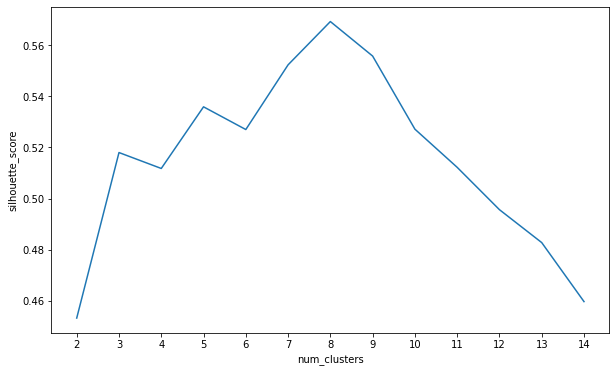

In [84]:
n_clusters = range(2, 15)
silhouette_scores = []
inertias = []

for i in n_clusters:
    kmeans = KMeans(n_clusters=i)
    labels = kmeans.fit_predict(df)
    silhouette_scores.append(silhouette_score(df, labels))
    inertias.append(kmeans.inertia_)

results_plot = pd.DataFrame({'num_clusters': n_clusters, 
                            'silhouette_score': silhouette_scores, 
                            'inertia': inertias})

plt.figure(figsize=(10, 6))
sns.lineplot(x="num_clusters", y="inertia", data = results_plot)
plt.xticks(n_clusters)
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x="num_clusters", y="silhouette_score", data = results_plot)
plt.xticks(n_clusters)
plt.show()

Silhouette score jednoznacznie wskazuje nam, że optymalna liczba klastrów to 8, natomiast ciężko byłoby wskazać "łokieć" na górnym rysunku. Zasada łokcia jest bardzo intuicyjna, ale w niektórych przypadkach wykorzystując tylko tę metodę moglibyśmy popełnić błąd albo po prostu wybrać różnie. Dlatego rzeczą wartą uwagi wydaje się pewne sformalizowanie metody łokcia, jakim jest metoda gap statisitcs zaproponowana przez Roberta Tibshirani w 2000 roku. Głównym pomysłem jest porównanie inercji klastrów z danych pierwotnych do inercji danych ze zbioru referencyjnego wygenerowanego sztucznie, bez widocznych naturalnych klastrów. Optymalnym wyborem w tej metodzie będzie taka liczba klastrów, dla której różnica będzie największa. 

In [94]:
reference_inertia = []
for i in n_clusters:
    local_inertia = []
    for _ in range(10):
        reference = np.random.rand(*df.shape)
        kmeans = KMeans(n_clusters=i)
        assignments = kmeans.fit_predict(reference)
        local_inertia.append(kmeans.inertia_)
    reference_inertia.append(np.mean(local_inertia))
gap = np.log(reference_inertia)-np.log(inertias)

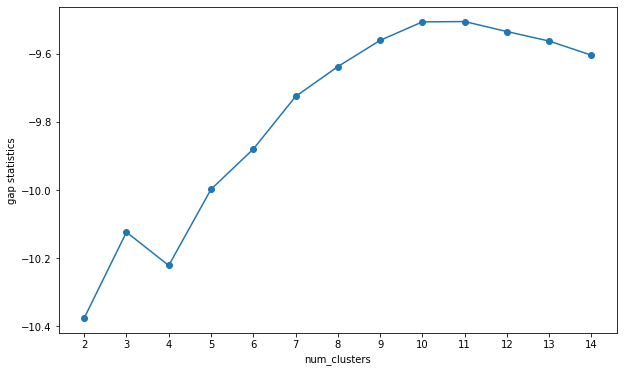

In [95]:
plt.figure(figsize=(10, 6))
plt.plot(n_clusters, gap,
         '-o', label='data')
plt.xticks(n_clusters)
plt.xlabel("num_clusters")
plt.ylabel("gap statistics")
plt.show()

W przypadku gap statistics najoptymalniejszą liczbą klastrów okazałoby się 10 lub 11. Natomiast możemy też wziąć pod uwagę dynamikę wzrostu tej funkcji, wówczas dobre liczby klastrów to 8 i 9. Pamiętajmy również, że dużo zależy tutaj od losowości wartości nowo wygenerowanych danych i losowości samej metody klasteryzacji, która jest przecież niedeterministyczna. Ostatecznie w tym przypadku zdecydowałbym się na 8 klastrów. Wówczas przypisanie do klastrów przedstawia się następująco: 

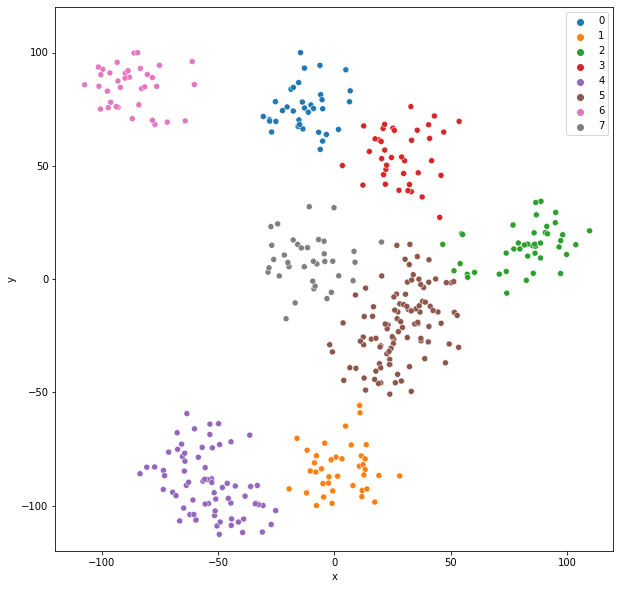

In [101]:
labels = KMeans(n_clusters=8).fit_predict(df)

plt.figure(figsize=(10, 10))
sns.scatterplot(x="x", y="y", data = df, hue=labels, palette=sns.color_palette("tab10")[:8])
plt.ylim([-120, 120])
plt.xlim([-120, 120])
plt.show()

Sprawdźmy jeszcze, co się stanie dla ustandaryzowanych danych. 

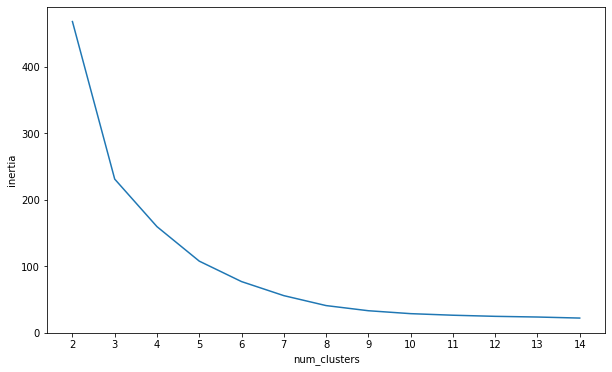

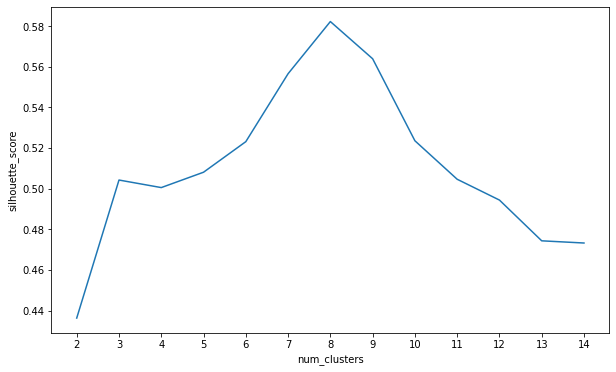

In [106]:
from sklearn.preprocessing import StandardScaler

df_std = StandardScaler().fit_transform(df)
n_clusters = range(2, 15)
silhouette_scores = []
inertias = []

for i in n_clusters:
    kmeans = KMeans(n_clusters=i)
    labels = kmeans.fit_predict(df_std)
    silhouette_scores.append(silhouette_score(df_std, labels))
    inertias.append(kmeans.inertia_)

results_plot = pd.DataFrame({'num_clusters': n_clusters, 
                            'silhouette_score': silhouette_scores, 
                            'inertia': inertias})

plt.figure(figsize=(10, 6))
sns.lineplot(x="num_clusters", y="inertia", data = results_plot)
plt.xticks(n_clusters)
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x="num_clusters", y="silhouette_score", data = results_plot)
plt.xticks(n_clusters)
plt.show()

Tak jak mogliśmy się spodziewać - w tym przypadku takie skalowanie niewiele zmienia rezultaty. 

### Klasteryzacja metodą hierarchiczną aglomeracyjną
Jako drugą metodę wykorzystam klasteryzację aglomeracyjną z różnymi metrykami odległości między klastrami. Wykorzystam implementację z bilioteki scipy, która pozwala generować również dendrogramy klasteryzacji, mogące pomóc w ostatecznym doborze liczby klastrów. 

Ponadto wykorzystam też indeks Daviesa-Bouldina, który jest definiowany intuicyjnie jako średnia miara podobieństwa każdego klastra z najbliższym mu klastrem, gdzie podobieństwo to stosunek odległości obiektów wewnątrz klastra do odległości pomiędzy klastrami. Zatem bardziej oddalone i odseparowane klastry mają lepszy rezultat - minimalna wartość to 0 i czym mniejsza, tym lepsza.

Wykorzystam również indeks Calińskiego-Harabasza, który jest obliczany jako stosunek wariancji sum kwadratów odległości obiektów od środka klastra do wariancji sum kwadratów odległości między klastrami. Czym wyższa wartość, tym lepsza klasteryzacja.

In [112]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

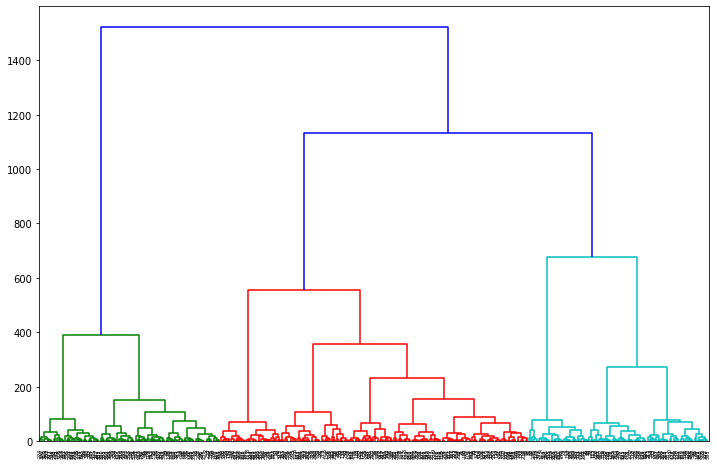

In [104]:
distances_matrix = linkage(df, method='ward')
plt.figure(figsize=(12, 8))
dendrogram(distances_matrix)
plt.show()

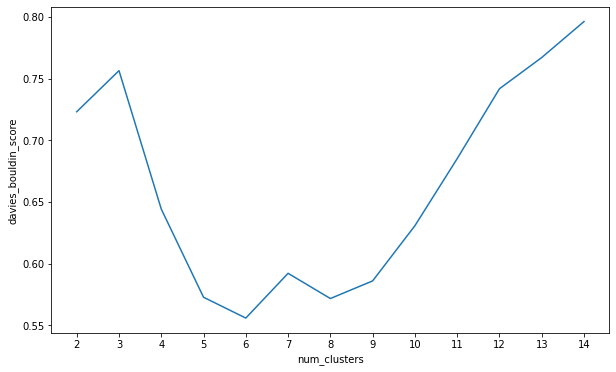

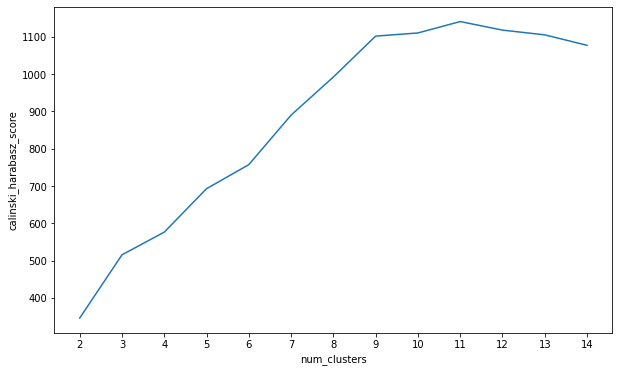

In [113]:
davies_bouldin_scores = []
calinski_harabasz_scores = []
for i in n_clusters:
    labels = fcluster(distances_matrix, i, criterion = "maxclust")
    davies_bouldin_scores.append(davies_bouldin_score(df, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(df, labels))

results_plot = pd.DataFrame({'num_clusters': n_clusters, 
                            'davies_bouldin_score': davies_bouldin_scores,
                            'calinski_harabasz_score': calinski_harabasz_scores})

plt.figure(figsize=(10, 6))
sns.lineplot(x="num_clusters", y="davies_bouldin_score", data = results_plot)
plt.xticks(n_clusters)
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x="num_clusters", y="calinski_harabasz_score", data = results_plot)
plt.xticks(n_clusters)
plt.show()

Według indeksu Daviesa-Bouldina najlepszą liczbą klastrów byłoby 6, chociaż 5, 8 i 9 również wydaje się sensownym wyborem. Natomiast na wykresie wartości indeksu Calińskiego-Harabasza widać wyraźnie odcięcie dla liczby klastrów równej 9. Także ta wartość wydaje mi się najtrafniejsza, patrząc na dendrogram, na którym jest to odcięcie na wysokości odległości ok. 200. 
Dla tak dobranej liczby klastrów, przypisanie do klastrów wygląda następująco: 

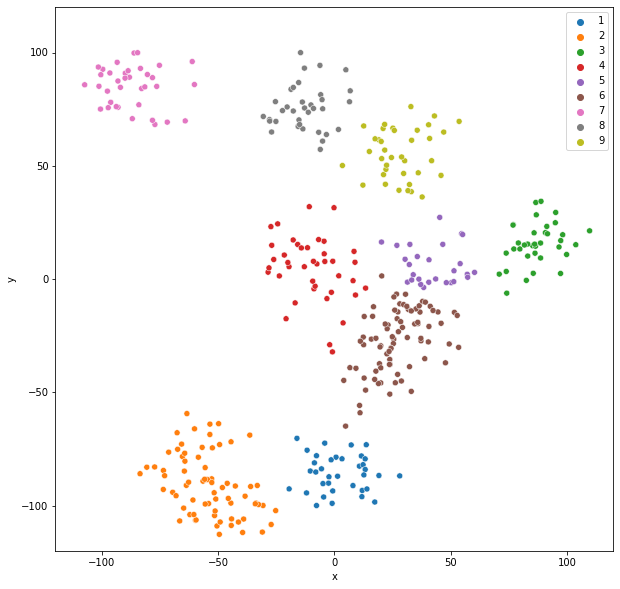

In [114]:
labels = fcluster(distances_matrix, 9, criterion = "maxclust")

plt.figure(figsize=(10, 10))
sns.scatterplot(x="x", y="y", data = df, hue=labels, palette=sns.color_palette("tab10")[:9])
plt.ylim([-120, 120])
plt.xlim([-120, 120])
plt.show()

Poniżej znajduje się kod podobny do powyższego, ale z wykorzystaniem innej miary odległości w klasteryzacji - połączenie kompletne. Wówczas również liczba klastrów równa 9 wydaje się być najoptymalniejszą na podstawie zaproponowanych sposobów doboru.

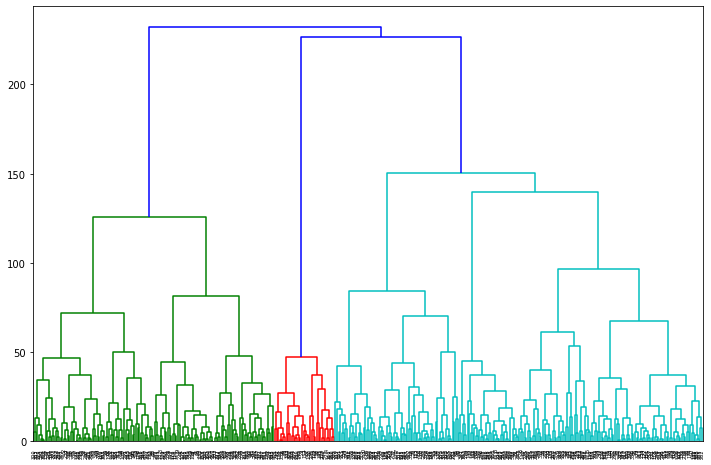

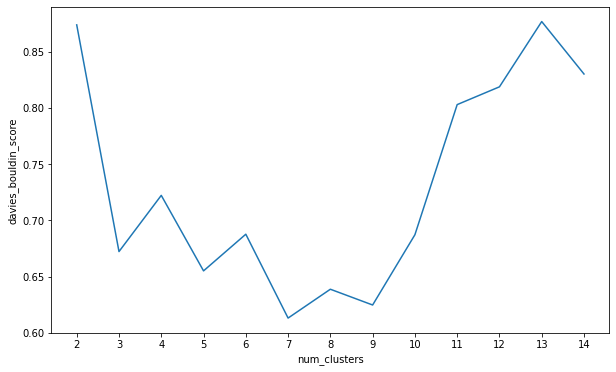

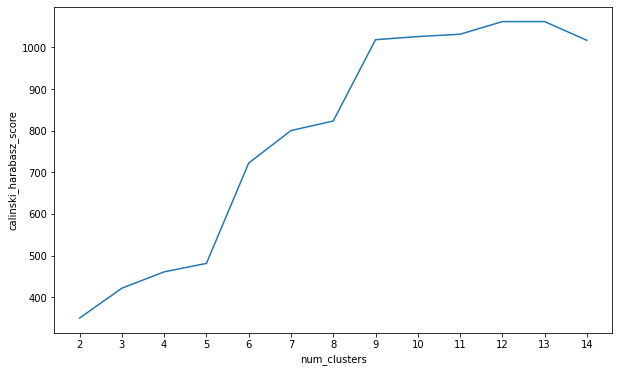

In [115]:
distances_matrix = linkage(df, method='complete')
plt.figure(figsize=(12, 8))
dendrogram(distances_matrix)
plt.show()
davies_bouldin_scores = []
calinski_harabasz_scores = []
for i in n_clusters:
    labels = fcluster(distances_matrix, i, criterion = "maxclust")
    davies_bouldin_scores.append(davies_bouldin_score(df, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(df, labels))

results_plot = pd.DataFrame({'num_clusters': n_clusters, 
                            'davies_bouldin_score': davies_bouldin_scores,
                            'calinski_harabasz_score': calinski_harabasz_scores})

plt.figure(figsize=(10, 6))
sns.lineplot(x="num_clusters", y="davies_bouldin_score", data = results_plot)
plt.xticks(n_clusters)
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x="num_clusters", y="calinski_harabasz_score", data = results_plot)
plt.xticks(n_clusters)
plt.show()

W przypadku klasteryzacji z wykorzystaniem takiej metody połączenia końcowe klastry wyglądają jednak nieco inaczej, co widać na poniższym rysunku:

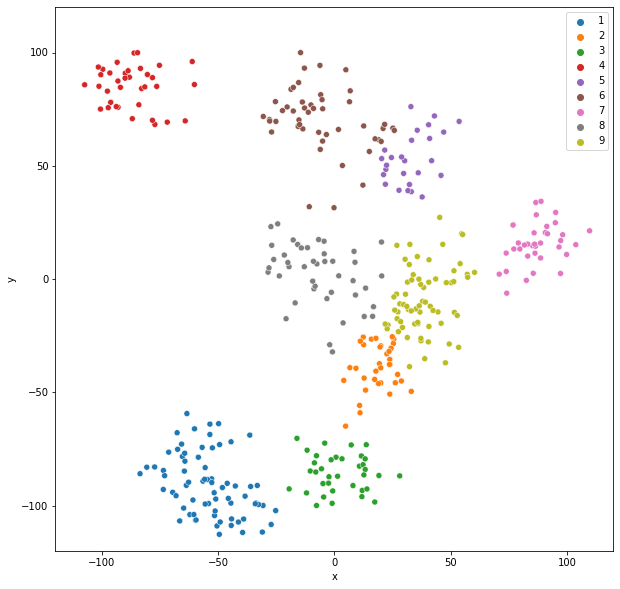

In [121]:
labels = fcluster(distances_matrix, 9, criterion = "maxclust")
plt.figure(figsize=(10, 10))
sns.scatterplot(x="x", y="y", data = df, hue=labels, palette=sns.color_palette("tab10")[:9])
plt.ylim([-120, 120])
plt.xlim([-120, 120])
plt.show()

### Wnioski
W klasteryzacji bez wzorca może nie być jednej "dobrej" odpowiedzi odnośnie liczy klastrów i podziału - to zależy od wybranej metody klasteryzacji, metryki, a nawet losowości. W związku z tym ważne jest, żeby nie polegać na tylko jednej metodzie. Mając ogólniejszy wgląd, możemy lepiej ocenić, jaki podział na klastry będzie najodpowiedniejszy w przypadku danego zbioru. 

Ponadto, trzeba pamiętać, że nawet taka sama liczba klastrów nie oznacza takiego samego podziału na klastry przy użyciu różnych algorytmów. 